## 实战项目：图像标注

---

在这个notebook中，我们将要使用之前训练过的模型为测试数据集中的图像生成标注。

## Step 1: 获取测试数据集的数据加载器

在运行下面的代码单元格之前，请在`transform_test`中定义要用于预处理测试图像的转换。

请确保你在此处定义的转换与之前在在训练阶段中用于预处理训练图像的转换是一致的。例如，如果你对训练图像进行了归一化，则还应对测试图像应用相同的归一化处理。

In [1]:
import sys
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms
import warnings
warnings.filterwarnings('ignore')

transform_test = transforms.Compose([ 
    transforms.Resize(256),                          
    transforms.RandomCrop(224),             
    transforms.ToTensor(),                           
    transforms.Normalize((0.485, 0.456, 0.406),      
                         (0.229, 0.224, 0.225))])


data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


在应用预处理之前，运行下面的代码单元格，将示例测试图像可视化。

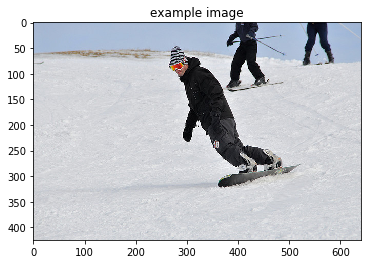

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

orig_image, image = next(iter(data_loader))

plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: 加载训练模型

在下一个代码单元格中，我们定义了一个`device`，将使用它将PyTorch张量移动到GPU中（如果CUDA可用的话）。在继续下一步之前，请运行此代码单元格。

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


在运行下面的代码单元格之前，请完成以下任务。

### 任务 #1

在下一个代码单元格中，你将从之前的notebook（即**Training.ipynb**）中加载已被训练的编码器和解码器。要实现此目的，你必须在`models/`文件夹中定义已保存的编码器和解码器文件的名称。

### 任务＃2

插入嵌入尺寸和解码器隐藏层的尺寸，与`decoder_file`中选定的pickle文件相对应。

In [4]:
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

encoder_file = "encoder-3.pkl" 
decoder_file = "decoder-3.pkl"

embed_size = 256
hidden_size = 512

vocab_size = len(data_loader.dataset.vocab)

encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

#加载编码器和解码器的权重文件.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

#如果支持cuda的话，交给cuda计算
encoder.to(device)
decoder.to(device)

DecoderRNN(
  (word_embeddings): Embedding(8855, 256)
  (lstm): LSTM(256, 512, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=512, out_features=8855, bias=True)
)

<a id='step3'></a>
## Step 3: 完成取样器

在执行下一个代码单元格之前，我们需要要编写**model.py**中的`DecoderRNN`类的`sample` 方法。该方法应接收包含对应于单个图像的嵌入输入特征的PyTorch张量`features`作为输入。

作为输出，它应该返回一个Python列表`output`，用于指示预测的语句。 `output[i]`是一个非负整数，用于标识句子中预测的第`i`个标记。你可以通过检查`data_loader.dataset.vocab.word2idx` 或 `data_loader.dataset.vocab.idx2word`来探索整数和标记之间的对应关系。

实现`sample`方法后，运行下面的代码单元格。如果单元格返回一个断言错误，请在继续操作之前按照说明修改代码，但请勿修改下面单元格中的代码。

In [6]:
image = image.to(device)

#在第二个维增加一个维度，encoder的输出shape是(1,256),执行unsqueeze(1)后，变为(1,1,256)，这样才符合sample的数据格式
features = encoder(image).unsqueeze(1)

#获得图像的标注说明单词索引集合
output = decoder.sample(features)
print('example output:', output)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

example output: [0, 3, 98, 39, 3, 2302, 77, 32, 514, 18, 1]


<a id='step4'></a>
## Step 4: 清理标注

在下面的代码单元格中，完成`clean_sentence`函数。它应把一个整数列表（对应于**Step 3**中的变量`output`）作为输入并返回相应的预测语句（作为单个Python字符串）。

In [7]:
#将单词的索引转换为对应的文字，同时把<start>和<end>符号去掉
def clean_sentence(output):
    sentence = ''
    word_list = []
    for index in output:
        if (index !=0) and (index!=1):
            word_list.append(data_loader.dataset.vocab.idx2word[index] + " ")
    sentence = sentence.join(word_list)
    return sentence

完成上面的`clean_sentence`函数后，运行下面的代码单元格。如果单元格返回一个断言错误，请在继续操作之前按照说明修改代码。

In [8]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: a person on a snowboard in the snow . 


<a id='step5'></a>
## Step 5: 生成预测！

在下面的代码单元格中，我们编写了一个函数(`get_prediction`，你可以使用该函数遍历测试数据集中的图像并输出模型的预测描述。

In [9]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    sentence = clean_sentence(output)
    print(sentence)

运行下面的代码单元格，测试此函数的运行方式。如果你愿意的话，可以尝试多次运行。

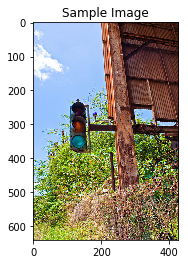

a street sign with a street sign on it 


In [10]:
get_prediction()

最后，我们要做的是遍历图像，直到找到四个感兴趣的图像标注对：
- 其中，有两个应该包括图像标注对，且该标注对会突出显示模型表现良好的实例。
- 另外两个应突出显示图像标注对，且该标注对会突出显示模型效果不佳的实例。

使用下面的四个代码单元格来完成此任务。

### 该模型表现良好！


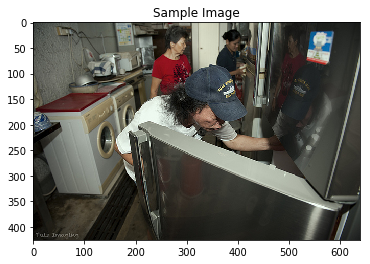

a man standing in a kitchen with a refrigerator . 


In [12]:
get_prediction()

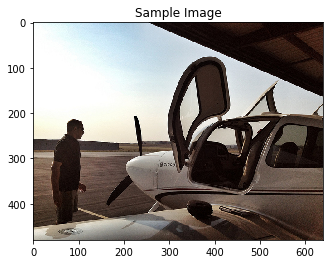

a large airplane is parked on the runway . 


In [15]:
get_prediction()

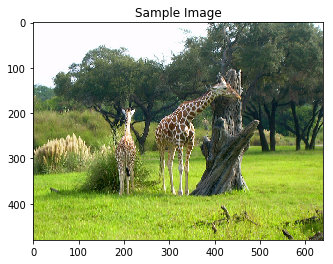

a giraffe standing in a field of grass . 


In [22]:
get_prediction()

### 该模型表现不佳......


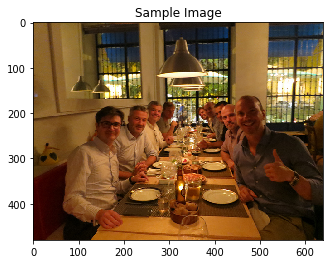

a man and woman are eating pizza at a restaurant . 


In [28]:
get_prediction()

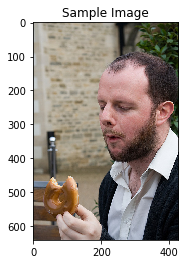

a man holding a cell phone in his hand . 


In [39]:
get_prediction()